In [1]:
using Pkg

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "TissueRigidity"
 
projectname()

"TissueRigidity"

In [2]:
using DifferentialEquations
using StatsBase
using CairoMakie
using XLSX
using DataFrames
using Optimization, OptimizationPolyalgorithms, SciMLSensitivity,OptimizationOptimJL,OptimizationBBO,OptimizationNOMAD

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception = (LoadError("/Users/boothh/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveEnzymeExt.jl", 1, ArgumentError("Package LinearSolve does not have Enzyme in its dependencies:\n- You may have a partially installed environment. Try `Pkg.instantiate()`\n  to ensure all packages in the environment are installed.\n- Or, if you have LinearSolve checked out for development and have\n  added Enzyme as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011caf97cc, Ptr{Nothing} @0x000000011caf9a16, Ptr{Nothing} @0x00000001097b86bd, Ptr{Nothing} @0x00000001097efa6d, Ptr{Nothing} @0x00000001097ee84f, Ptr{Nothing} @0x00000001097ef039, Ptr{Nothing} @0x00000001097eecad, Ptr{Nothing} @0x00000001097efef5, Ptr{Nothing} @0x0000000126077c41, Ptr{Nothing} @0x0000000109

In [49]:
include(srcdirx("Plotting&Utility.jl"))
# include(srcdirx("FittingFunctions.jl"))
include(srcdirx("old/FittingFunctions_old_cmax.jl"))

include(srcdirx("NodalLefty_E.jl"))

exp_name = "NodalLefty_RelayDiffusion_v1"

include(srcdirx("ExperimentSetups/" * exp_name * ".jl"))

include(scriptsdirx("LoadData.jl"));

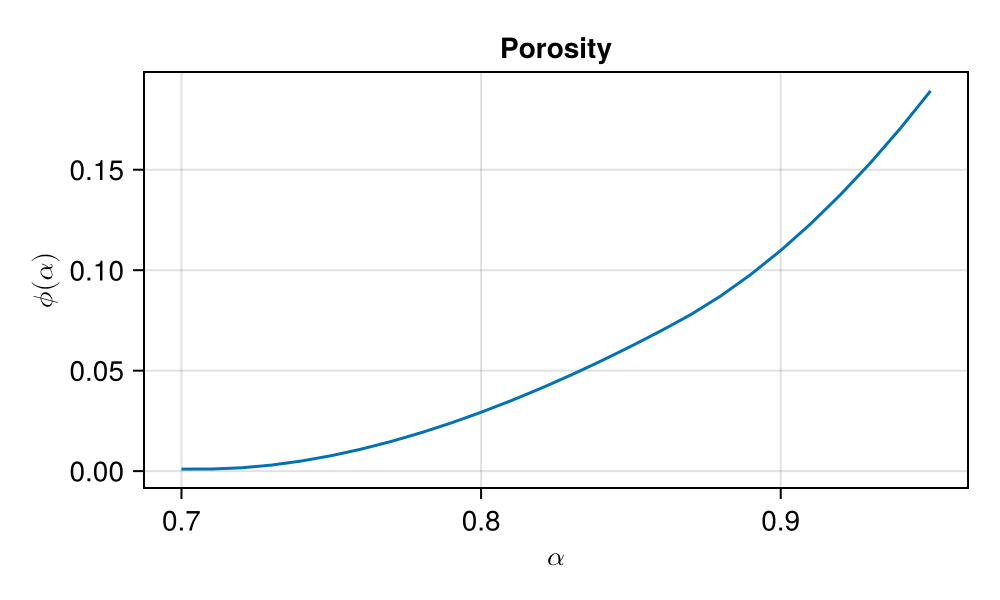

In [50]:
α_range = 0.7:0.01:0.95

fig = Figure(size = (500,300))
ax1 = Axis(fig[1,1],title = "Porosity",ylabel = L"\phi(\alpha)",xlabel = L"\alpha")

lines!(ax1, α_range,[ϕ(α) for α in α_range])

fig

In [52]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]
# pv_orig = load(datadirx() * "/sims/NodalLefty_DiffusionDominated_OptParmas.jld2")["OptimalParam"][3]

p_orig,p_cp_orig,p_lm_orig = get_params(pv_orig)

tspan = (0,Inf)

u0 = ones(Nc,4)

u0[:,1] .= 1e-10
u0[:,2] .= 1e-10
u0[:,3] .= 0.
u0[:,4] .= α0

prob = ODEProblem(nodal_lefty_spatial_diff!,u0,tspan,p_orig)

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

lb[3:end] = (1 - γ) .* lb[3:end]
ub[3:end] = (1 + γ) .* ub[3:end];

In [53]:
p_orig

(DN0 = 1.95, DL0 = 15.0, kN0 = 0.0025, kL0 = 1.25e-7, kE = 0.0002, kNL = 500000.0, σN0 = 0.3608, σL0 = 2.5e-6, Na = 48.1, NL = 122.79, NE = 24.05, mN = 2, mL = 8, mNL = 2, LN = 2.0, s0 = 5.0)

In [54]:
orig_metrics = get_summary_metrics(pv_orig,prob,data,alpha_data)

(wt_t0 = 1347.2194655015894, cp_t0 = 1897.1049616246871, wt_xMax = 62.207357859531776, cp_xMax = 79.26421404682274, lm_xMax = 184.6153846153846, wt_d0 = 0.04838709677419355, cp_d0 = 0.18987341772151897, lm_d0 = 0.059782608695652176, xmax_peak_ratio = 1.4081632653061225, xmax_mse = (0.11458696407714933, 0.19399054976568544), alpha_mse = 0.007752263893246061, cp_lprod_t0 = 1017.2881678277308, wt_lprod_t0 = 989.793893021576, retcodes = (SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated, SciMLBase.ReturnCode.Terminated))

In [90]:
t_check = [0,15,40,65,90,115,140] .* 60

# t_check = alpha_data_times_norm[2:end] .* orig_metrics[:wt_t0]

sol_profiles = solve(prob, p = p_orig, FBDF(),abstol = 1e-11,reltol = 1e-9, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);
sol_profiles_cp = solve(prob, p = p_cp_orig, FBDF(),abstol = 1e-11,reltol = 1e-9, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u), saveat = t_check);

dyn_N = [sol[:,1] for sol in sol_profiles.u[1:length(t_check)]]
dyn_L = [sol[:,2] for sol in sol_profiles.u[1:length(t_check)]];

dyn_N_cp = [sol[:,1] for sol in sol_profiles_cp.u[1:length(t_check)]];

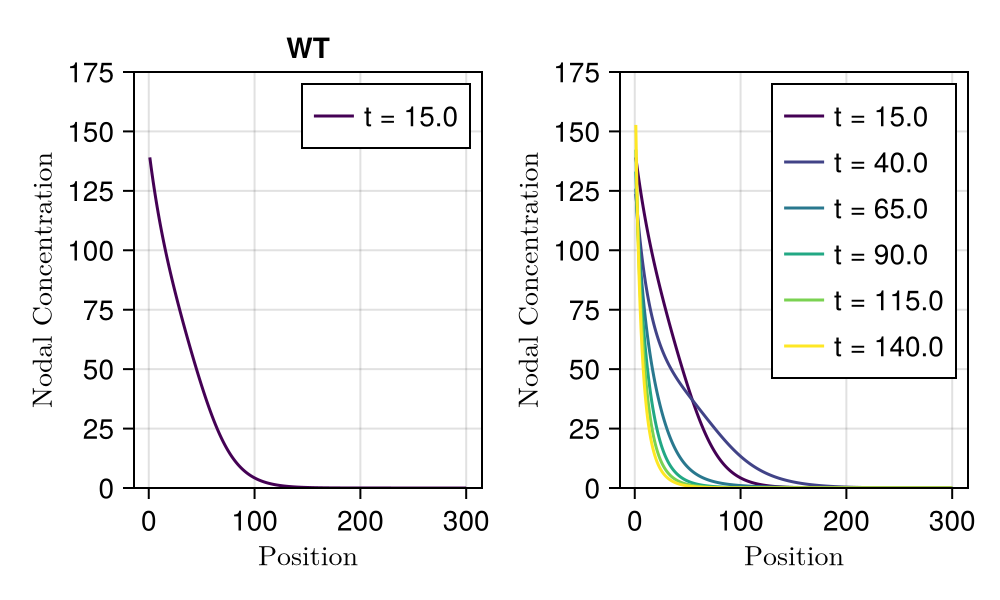

In [92]:
fig = Figure(size = (500,300))

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}", title = "WT")

lines!(ax1,dyn_N[2],label =   "t = " * string(t_check[2] / 60),colormap = :viridis, color = 1, colorrange = (1,length(t_check)-1))

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}" )

for (i,N) in enumerate(dyn_N[2:end])
    lines!(ax2,N,label = "t = " * string(t_check[i+1] / 60),colormap = :viridis, color = i, colorrange = (1,length(t_check)-1))
end

axislegend(ax1,position = :rt)
axislegend(ax2,position = :rt)


# xlims!(ax1,0,150.)
# xlims!(ax2,0,150.)

ylims!(ax1,0,175.)
ylims!(ax2,0,175.)

# ax1.yticks = (0:50:300,string.(0:50:300))
# ax2.yticks = (0:50:300,string.(0:50:300))

save(plotsdir(exp_name * "/OrigFits/NodalProfiles_WT.pdf"),fig)

fig

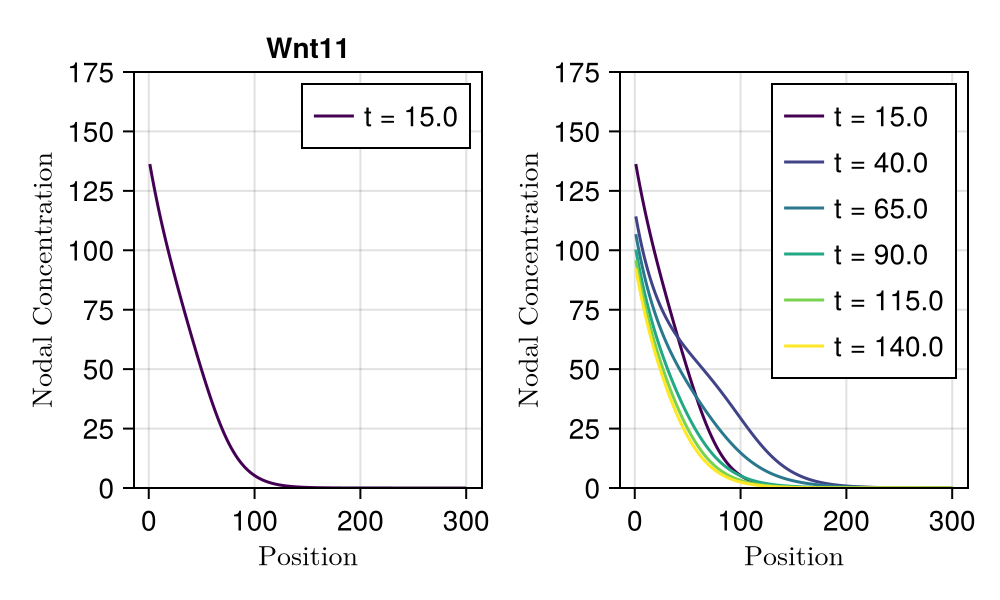

In [94]:
fig = Figure(size = (500,300))

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}", title = "Wnt11")

lines!(ax1,dyn_N_cp[2],label =   "t = " * string(t_check[2] / 60),colormap = :viridis, color = 1, colorrange = (1,length(t_check)-1))

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"\text{Nodal Concentration}" )

for (i,N) in enumerate(dyn_N_cp[2:end])
    lines!(ax2,N,label = "t = " * string(t_check[i+1] / 60),colormap = :viridis, color = i, colorrange = (1,length(t_check)-1))
end

axislegend(ax1,position = :rt)
axislegend(ax2,position = :rt)


# xlims!(ax1,0,150.)
# xlims!(ax2,0,150.)

ylims!(ax1,0,175.)
ylims!(ax2,0,175.)

# ax1.yticks = (0:50:300,string.(0:50:300))
# ax2.yticks = (0:50:300,string.(0:50:300))

save(plotsdir(exp_name * "/OrigFits/NodalProfiles_Wnt11.pdf"),fig)

fig

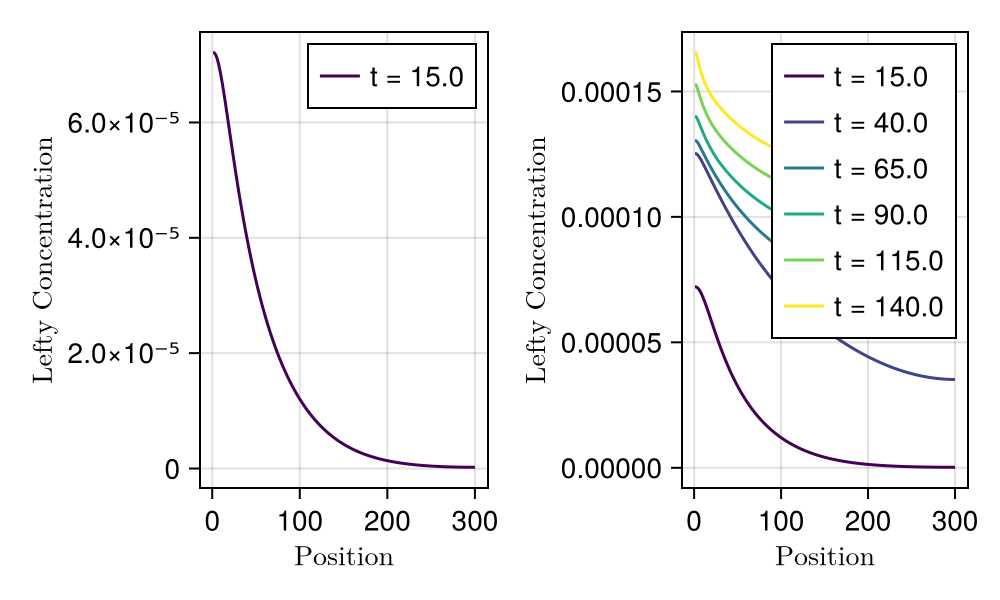

In [96]:
fig = Figure(size = (500,300))

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"\text{Lefty Concentration}" )

lines!(ax1,dyn_L[2],label ="t = " * string(t_check[2] / 60),colormap = :viridis, color = 1, colorrange = (1,length(t_check)-1))

ax2 = Axis(fig[1,2], xlabel = L"\text{Position}", ylabel= L"\text{Lefty Concentration}" )

for (i,N) in enumerate(dyn_L[2:end])
    lines!(ax2,N,label = "t = " * string(t_check[i+1] / 60),colormap = :viridis, color = i, colorrange = (1,length(t_check)-1))
end

axislegend(ax1,position = :rt)
axislegend(ax2,position = :rt)


# ylims!(ax1,0,100.)
# ylims!(ax2,0,100.)
# ax1.yticks = (0:50:300,string.(0:50:300))
# ax2.yticks = (0:50:300,string.(0:50:300))

save(plotsdir(exp_name * "/OrigFits/LeftyProfiles.pdf"),fig)

fig

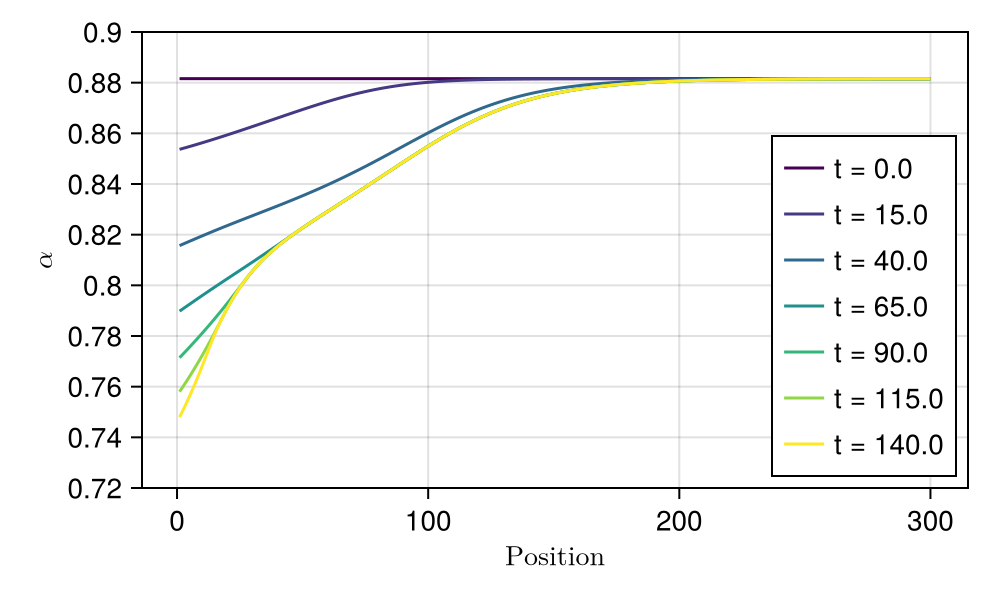

In [97]:
fig = Figure(size = (500,300))

ax1 = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"\alpha" )

dyn_alpha = [sol[:,4] for sol in sol_profiles.u[1:length(t_check)]]

for (i,N) in enumerate(dyn_alpha)
    lines!(ax1,N,label = "t = " * string(t_check[i] / 60),colormap = :viridis, color = i, colorrange = (1,length(t_check)))
end

ylims!(ax1,0.72,0.9)

ax1.yticks = (0.7:0.02:0.9,string.(0.7:0.02:0.9))

axislegend(ax1,position = :rb)

save(plotsdir(exp_name * "/OrigFits/AlphaProfiles.pdf"),fig)

fig

In [81]:
p_orig,p_orig_cp,p_orig_lm,p_orig_ro, p_orig_ro_cp,p_orig_ro_cp_lm = get_params_v1(pv_orig)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = p_cp_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_lm = solve(prob, p = p_lm_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_ro = solve(prob, p = p_orig_ro, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

sol_ro_cp = solve(prob, p = p_orig_ro_cp, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_ro_cp_lm = solve(prob, p = p_orig_ro_cp_lm, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

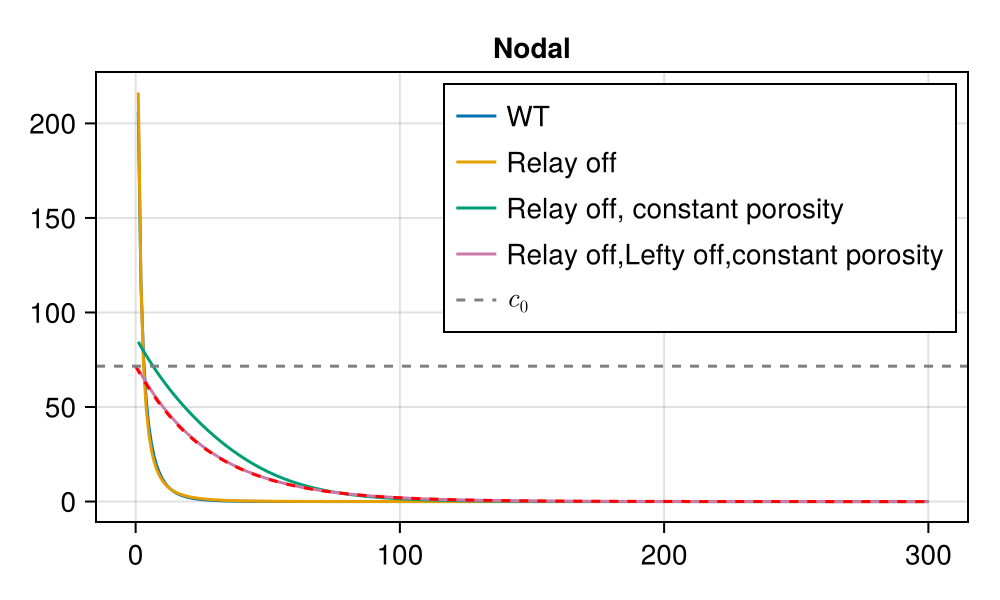

In [67]:
fig = Figure(size = (500,300))
ax = Axis(fig[1,1],title = "Nodal")

lines!(ax,sol.u[end][:,1],label = "WT")
lines!(ax,sol_ro.u[end][:,1],label = "Relay off")
lines!(ax,sol_cp.u[end][:,1],label = "Relay off, constant porosity")
lines!(ax,sol_ro_cp_lm.u[end][:,1],label = "Relay off,Lefty off,constant porosity")
lines!(ax,tissue,y->c0*exp(-y/λ),linestyle = :dash,color = :red)

hlines!(ax,c0, linestyle = :dash, color = :grey,label = L"c_0")

axislegend(ax,position = :rt)

save(plotsdir(exp_name * "/OrigFits/NodalProfiles_Variations.pdf"),fig)

fig

In [19]:
data_metrics = get_exp_summary_metrics(data)

(wt_t0 = 6000.0, cp_t0 = 8400.0, wt_xMax = 63.9966, cp_xMax = 86.59800000000001, wt_d0 = 0.0, cp_d0 = 0.0, lm_d0 = 1.0, xmax_peak_ratio = 1.4, xmax_mse = 0.0, alpha_mse = 0.0)

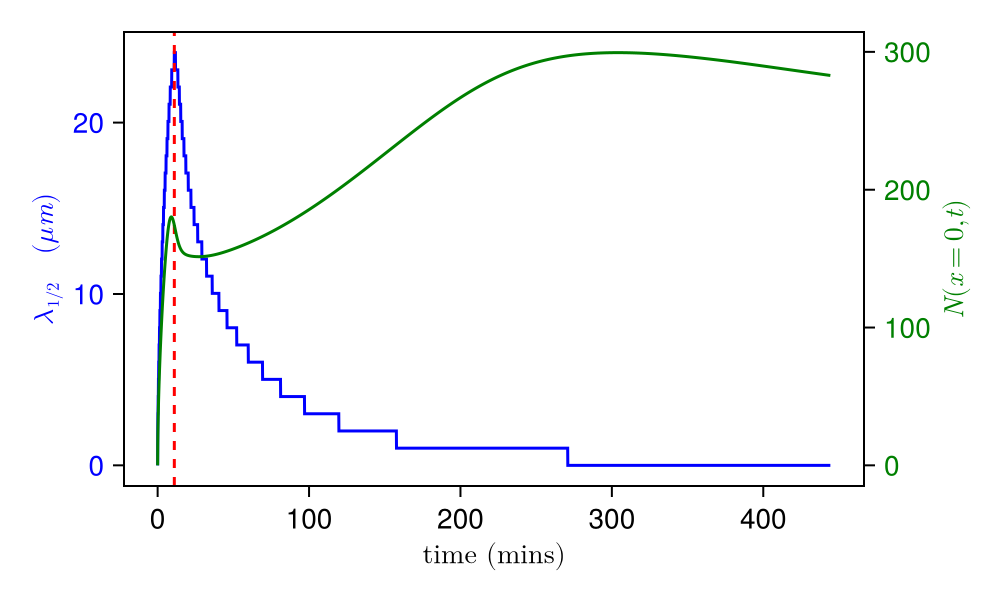

In [20]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{time (mins)}", ylabel= L"\lambda_{1/2} \quad (\mu m)",ygridvisible = false,xgridvisible = false,ylabelcolor = :blue,yticklabelcolor = :blue)
ax_N = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"N(x=0,t)", yaxisposition = :right,ylabelcolor = :green,yticklabelcolor = :green,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_N)

sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

N_samp = 5000

λ_trange = LinRange(0.,sol.t[end],N_samp)

N0t = [sol(t)[1,1] for t in λ_trange]

λhalf,λhalf_max_t = get_lambda_half(sol,λ_trange)

c_max = maximum(sol(λhalf_max_t)[:,1])

lines!(ax,λ_trange ./ 60 ,λhalf,color = :blue)

lines!(ax_N,λ_trange ./ 60 ,N0t, color = :green)

vlines!(ax,λhalf_max_t / 60, color = :red, linestyle = :dash)

# save(plotsdir(exp_name * "/OrigFits/LambdaHalfOverT.pdf"),fig)

fig

In [98]:
(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm_rescaled )),(porosity_dyn,porosity_dyn_cp),c_level = get_alpha_xmax(pv_orig,prob);

In [99]:
c_level

41.950156062397845

In [100]:
sol = solve(prob, p = p_orig, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = p_cp_orig, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_lm = solve(prob, p = p_lm_orig, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

In [101]:
# porosity_dyn_lm = [mean(ϕ.(sol_lm(t)[1:50,4])) for t in t_plot .* orig_metrics[:wt_t0]];

In [102]:
include(srcdirx("old/FittingFunctions_old_cmax.jl"))

generate_param_set (generic function with 1 method)

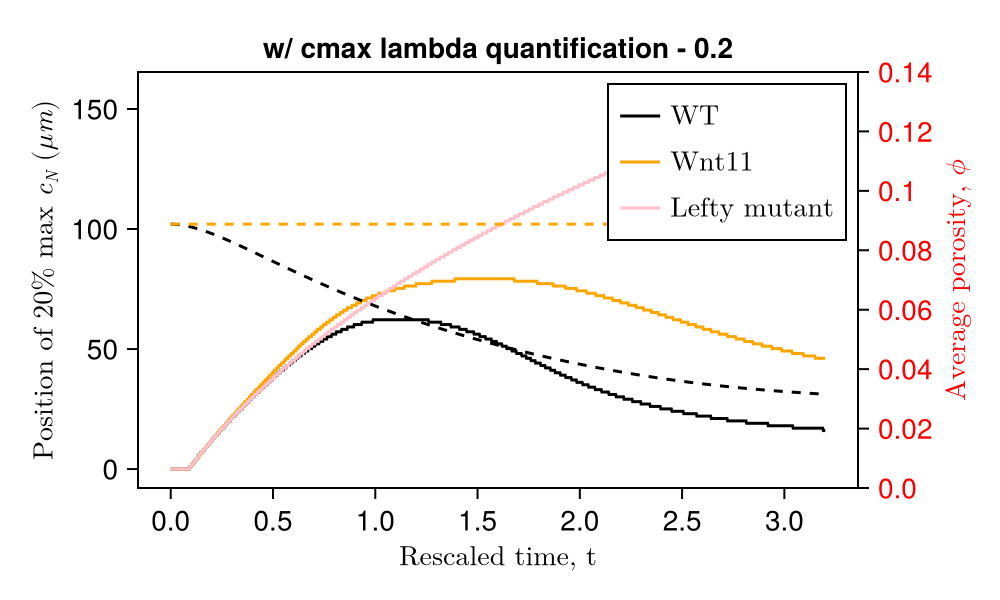

In [103]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false,title = "w/ cmax lambda quantification - 0.2")
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

lines!(ax,t_plot,level_x_wt_rescaled,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled,color = :orange,label = L"\text{Wnt11}")
lines!(ax,t_plot,level_x_lm_rescaled,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

# lines!(ax_por,t_plot,porosity_dyn_lm ,linestyle = :dash,color = :pink,label = L"\text{ϕ}")

# lines!(ax,exp_times_times_norm ,data[:,"SLB"],color = :blue)
# lines!(ax,exp_times_times_norm ,data[:,"WT"],color = :black)

axislegend(ax,position = :rt)

ylims!(ax_por,0.,0.14)
# ylims!(ax,0.,300)
ax.xticks = (0:0.5:3.5,string.(0:0.5:3.5))

ax_por.yticks = (0:0.02:0.14,string.(0:0.02:0.14))

save(plotsdir(exp_name * "/OrigFits/Fig3E_xmax_over_time.pdf"),fig)

fig

In [74]:
t_plot_int = LinRange(0,3*orig_metrics[:wt_t0],1000)

1000-element LinRange{Float64, Int64}:
 0.0,4.0457,8.09141,12.1371,16.1828,20.2285,…,4029.52,4033.57,4037.61,4041.66

In [75]:
νN_int_cp,νN_int = get_integrated_lefty_prod_values(sol,sol_cp,t_plot_int)

([1.4464625771684933e-100, 1.336237763926548e-16, 3.671531009652596e-15, 2.4894652941492544e-14, 9.611169417032585e-14, 2.7326554782618456e-13, 6.410589665721625e-13, 1.3179726100322748e-12, 2.4613603120010264e-12, 4.272728023179183e-12  …  3.969076721585352e-6, 3.962547993554176e-6, 3.956030207963027e-6, 3.949523366119799e-6, 3.943027469976735e-6, 3.936542521987337e-6, 3.930068524494434e-6, 3.92360547971485e-6, 3.9171533897404344e-6, 3.91071225653903e-6], [1.4464625771684933e-100, 1.3372199486207397e-16, 3.678750272471259e-15, 2.4978739276550366e-14, 9.658394073379816e-14, 2.750548376007587e-13, 6.463569542107934e-13, 1.3312208765534746e-12, 2.4906550308820468e-12, 4.331721492325754e-12  …  3.9507557517359484e-6, 3.94885909788493e-6, 3.946974418538359e-6, 3.945101654406843e-6, 3.9432407463228974e-6, 3.941391634527734e-6, 3.939554259179509e-6, 3.9377285606735215e-6, 3.93591447917197e-6, 3.9341119543263916e-6])

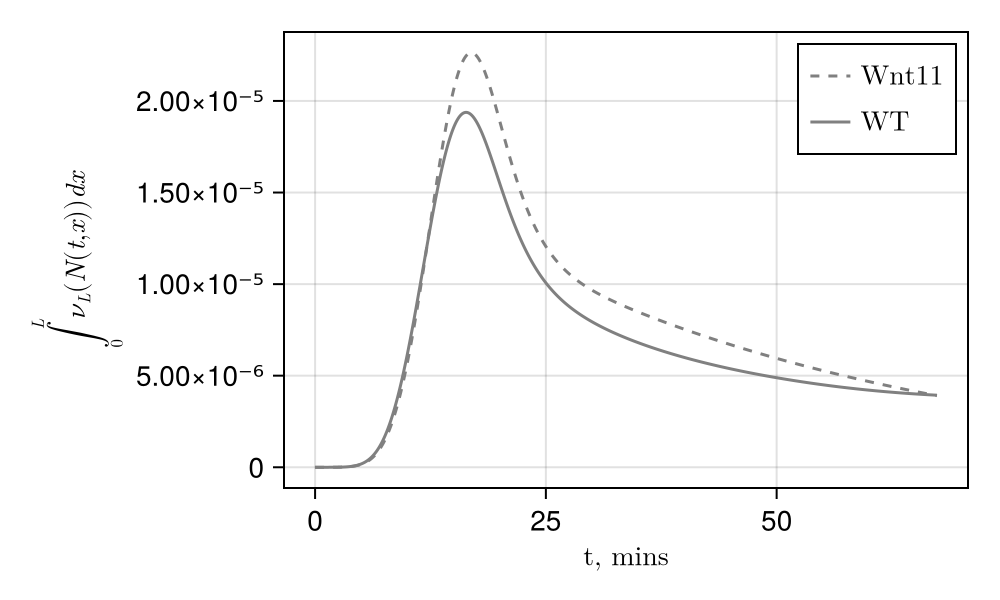

In [76]:
fig = Figure(size = (500,300))
ax = Axis(fig[1,1], xlabel = L"\text{t, mins}", ylabel= L"\int_0^L ν_L(N(t,x)) dx" )

lines!(ax,t_plot_int./ 60,νN_int_cp,linestyle = :dash,color = :grey, label = L"\text{Wnt11}")
lines!(ax,t_plot_int./ 60,νN_int,color = :grey, label = L"\text{WT}")

# xlims!(ax,0.,100)

# ylims!(ax,0.,0.16)

axislegend(ax,position = :rt)

save(plotsdir(exp_name * "/OrigFits/Fig4h_Integrated_Lprod_over_Time.pdf"),fig)

fig

In [ ]:
pv_orig = [DN0,DL0,kN0,kL0,kE,kNL,σN0,σL0,Na,NL,NE,LN,s0]

In [ ]:
γ = 0.99

lb = copy(pv_orig)
ub = copy(pv_orig)

lb[1:2] = 0.9 .* lb[1:2]
ub[1:2] = 1.1 .* ub[1:2]

# knl , sigma_n not large enough

lb[3:end] = 0.5 .* lb[3:end]
ub[3:end] = 2 .* ub[3:end];

lb[6] = 1.
ub[6] = 500.

j = 1.

lb_pow = copy(pv_orig)
ub_pow = copy(pv_orig)

lb_pow[1:2] = 0.9 .* lb_pow[1:2]
ub_pow[1:2] = 1.1 .* ub_pow[1:2]

lb_pow[3:end] = 10^(-j) .* lb_pow[3:end]
ub_pow[3:end] = 10^(j) .* ub_pow[3:end];

lb_pow[6] = 9.99

ub_pow

In [ ]:
ro,obj = optimize_params(prob,0.2,pv_orig,lb,ub,250)

In [ ]:
safesave("OptimizationRuns/" * exp_name * "_01.jld2", Dict("Params"=>ro,"Obj" => obj))

In [ ]:
ro1,obj1 = optimize_params(prob,0.2,pv_orig,lb_pow,ub_pow,500)

In [ ]:
safesave("OptimizationRuns/" * exp_name * "_02.jld2", Dict("Params"=>ro1,"Obj" => obj1))

In [ ]:
ro2,obj2 = optimize_params(prob,0.05,pv_orig,lb_pow,ub_pow,500)

In [ ]:
safesave("OptimizationRuns/" * exp_name * "_005.jld2", Dict("Params"=>ro2,"Obj" => obj2))

In [ ]:
p_opt,p_cp_opt,p_lm_opt = get_params(ro)

p_opt_metrics = get_summary_metrics(ro,prob,data,alpha_data,0.1)

In [ ]:
data_metrics[:cp_xMax] / data_metrics[:wt_xMax]

In [ ]:
# a = []
# push!(a,result_opt.u)

In [ ]:
sol = solve(prob, p = p_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_lm = solve(prob, p = p_cp_opt, FBDF(),abstol = de_abstol,reltol = de_reltol, maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));
sol_cp = solve(prob, p = p_lm_opt, FBDF(),abstol = de_abstol,reltol = de_reltol,maxiters = 1e6,callback = TerminateSteadyState(1e-6,1e-4),isoutofdomain = (u,p,t) -> any(x->x<0, u));

In [ ]:
(t_grid_alpha,dyn_alpha),(t_plot,(level_x_wt_rescaled,level_x_cp_rescaled,level_x_lm_rescaled )),(porosity_dyn,porosity_dyn_cp),c_level,(sol,sol_cp,sol_lm) = get_alpha_xmax_lambda(pv_orig,prob,0.1);

In [ ]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Position}", ylabel= L"α(t)" )

for (n,d) in enumerate(dyn_alpha)
    lines!(ax,alpha_x,d, label = string(alpha_data_times_norm[n])* "* t_wt")
    scatter!(ax,alpha_x,alpha_data[:,n+1])
end

axislegend(ax,position = :rb)

save(plotsdir(exp_name * "/OptFits/Alpha_over_time.pdf"),fig)

fig

In [ ]:
fig = Figure(size = (500,300))

ax = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Position of 20% max } c_N \text{ } (μm) ",ygridvisible = false,xgridvisible = false,title = "w/ cmax lambda quantification - 0.1")
ax_por = Axis(fig[1,1], xlabel = L"\text{Rescaled time, t}", ylabel= L"\text{Average porosity, } \phi", yaxisposition = :right,ylabelcolor = :red,yticklabelcolor = :red,ygridvisible = false,xgridvisible = false,xticksvisible = false)

hidexdecorations!(ax_por)

lines!(ax,t_plot,level_x_wt_rescaled,color = :black,label = L"\text{WT}")
lines!(ax,t_plot,level_x_cp_rescaled,color = :orange,label = L"\text{Wnt11}")
lines!(ax,t_plot,level_x_lm_rescaled,linestyle = :dash,color = :pink,label = L"\text{Lefty mutant}")

lines!(ax_por,t_plot,porosity_dyn ,linestyle = :dash,color = :black,label = L"\text{ϕ}")
lines!(ax_por,t_plot,porosity_dyn_cp ,linestyle = :dash,color = :orange,label = L"\text{ϕ}")

lines!(ax,exp_times_times_norm ,data[:,"SLB"],color = :blue)
lines!(ax,exp_times_times_norm ,data[:,"WT"],color = :black)

axislegend(ax,position = :rt)

ylims!(ax_por,0.,0.14)
ylims!(ax,0.,300)
ax.xticks = (0:0.5:3.5,string.(0:0.5:3.5))

ax_por.yticks = (0:0.02:0.14,string.(0:0.02:0.14))

save(plotsdir(exp_name * "/OptFits/Fig3E_xmax_over_time_wporosity_lambda_01.pdf"),fig)

fig

In [ ]:
p_opt

In [ ]:
safesave("OptimizationRuns/" * exp_name * ".jld2", Dict("Params"=>ro,"Obj" => obj))

In [ ]:
# to_plot = [:wt_t0,:cp_t0,:xmax_peak_ratio,:wt_xMax,:cp_xMax,:wt_d0,:cp_d0,:lm_d0,:alpha_mse]

# fig = Figure(size = (760,760))

# grid_ax = Tuple.(findall(x->x>0,ones(3,3)))

# for (n,metric) in enumerate(to_plot)
#     if metric  == :alpha_mse
#         ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric],xscale = log10)
#         hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6),bins = 50)
#         vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash)
#         vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash)
#     else
#         ax = Axis(fig[grid_ax[n]...],xlabel = metric_names_latex[metric])
#         hist!(ax,map(x->transformations[metric](x[metric]),sim_res),normalization = :probability,color = (:grey,0.6))
#         vlines!(ax,transformations[metric](data_metrics[metric]),color = :red,linestyle = :dash, label = L"\text{Experiment}")
#         vlines!(ax,transformations[metric](orig_metrics[metric]),color = :blue,linestyle = :dash, label = L"\text{Start param.}")
#         vlines!(ax,transformations[metric](p_opt_metrics[metric]),color = :green,linestyle = :dash, label = L"\text{Opt param.}")
#     end

#     if metric == :xmax_peak_ratio
#         axislegend(ax,position = :rt)
#     end

# end

# save(plotsdir(exp_name * "/OptFits/Summary_metrics.pdf"),fig)

# fig

In [ ]:
ro_pow,obj_pow = optimize_params(prob,0.1,pv_orig,lb_pow,ub_pow,200)

In [ ]:
p_opt